<a href="https://colab.research.google.com/github/antahiap/dsr-nlp/blob/main/notebooks/04_language_generation_lsdyna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
import glob
import random
import shutil
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras import models, layers
from tqdm import tqdm
import time

In [9]:
# Where the text files are going to live.
dataset_path = "dataset"
dataset_path_all = os.path.join(dataset_path, "all")
dataset_path_train = os.path.join(dataset_path, "train")
dataset_path_valid = os.path.join(dataset_path, "valid")

# Just use 20 files.
file_number = 20

# Gather the corpus if it has not been gathered yet.
if not os.path.exists(dataset_path):

    # Create all the folders.
    for path in [dataset_path, dataset_path_all, dataset_path_train, dataset_path_valid]:
        if not os.path.exists(path):
            os.mkdir(path)

    # Clone the repo.
    !git clone https://github.com/antahiap/dsr-nlp #https://github.com/vilmibm/lovecraftcorpus

    # Find all the files.
    paths_all = glob.glob("dsr-nlp/data/mat/*.txt")
    print(sorted(paths_all))

    # Do not use all.
    paths_all = paths_all[:file_number]

    # Split 80/20.
    split_index = int(len(paths_all) * 0.8)
    paths_train = paths_all[:split_index]
    paths_valid = paths_all[split_index:]

    # Copy files.
    def copy(paths, destination):
        for path in paths:
            shutil.copy2(path, destination)
    copy(paths_all, dataset_path_all)
    copy(paths_train, dataset_path_train)
    copy(paths_valid, dataset_path_valid)

    # Delete repo.
    !rm -rf dsr-nlp

    # Done.
    print("Corpus downloaded.")

Cloning into 'dsr-nlp'...
remote: Enumerating objects: 956, done.
remote: Counting objects: 100% (212/212), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 956 (delta 84), reused 194 (delta 75), pack-reused 744
Receiving objects: 100% (956/956), 88.75 MiB | 16.91 MiB/s, done.
Resolving deltas: 100% (118/118), done.
['dsr-nlp/data/mat/MAT_00.txt', 'dsr-nlp/data/mat/MAT_001.txt', 'dsr-nlp/data/mat/MAT_001_FLUID.txt', 'dsr-nlp/data/mat/MAT_002.txt', 'dsr-nlp/data/mat/MAT_002_ANIS.txt', 'dsr-nlp/data/mat/MAT_002_ANISO.txt', 'dsr-nlp/data/mat/MAT_003.txt', 'dsr-nlp/data/mat/MAT_004.txt', 'dsr-nlp/data/mat/MAT_005.txt', 'dsr-nlp/data/mat/MAT_006.txt', 'dsr-nlp/data/mat/MAT_007.txt', 'dsr-nlp/data/mat/MAT_008.txt', 'dsr-nlp/data/mat/MAT_009.txt', 'dsr-nlp/data/mat/MAT_010.txt', 'dsr-nlp/data/mat/MAT_010_SPALL.txt', 'dsr-nlp/data/mat/MAT_010_ST.txt', 'dsr-nlp/data/mat/MAT_011.txt', 'dsr-nlp/data/mat/MAT_011_LUND.txt', 'dsr-nlp/data/mat/MAT_012.txt', 'dsr-nlp/data/mat/MAT

# Data Setup

In [10]:
def create_dataset(data_path):
  dataset = preprocessing.text_dataset_from_directory(
      data_path,
      labels=None,
      batch_size=32,  # not training
      seed=42
  )
  return dataset

In [12]:
dataset_path_all

'dataset/all'

In [13]:
dataset_original_all = create_dataset(dataset_path_all)
dataset_original_train = create_dataset(dataset_path_train)
dataset_original_valid = create_dataset(dataset_path_valid)

Found 20 files belonging to 1 classes.
Found 16 files belonging to 1 classes.
Found 4 files belonging to 1 classes.


In [15]:
for batch in dataset_original_all:
  for sample in batch:
    print(sample)

tf.Tensor(b': *. R3: *.  \n*. R3 \n*. R3.  For .   *.   \n Data Card De\xef\xac\x81nitions: \n Card 1 1 2 3 4 5 6 7 8 \nVariable MID RO PR      \nType A F F      \nDefault none none none      \n \n VARIABLE   DESCRIPTION  \nMID Material identi\xef\xac\x81cation.  A unique number or label m ust be \nspeci\xef\xac\x81ed (see *PART). \nRO Mass density \nPR Poisson\xe2\x80\x99s ratio \n \n Card 2 1 2 3 4 5 6 7 8 \nVariable SIGF A0 A1 A2     \nType F F F F     \nDefault 0.0 0.0 0.0 0.0     \n \n VARIABLE   DESCRIPTION  \nSIGF Maximum principal stress for failure \nA0 Cohesion \nA1 Pressure hardening coe\xef\xac\x83cient \nA2 Pressure hardening coe\xef\xac\x83cient  \n *.   \n  VARIABLE   DESCRIPTION  \nSIGY Initial yield stress \nETAN Tangent modulus/plastic hardening modulus \nLCP Load curve ID giving rate sensitivity for principal  material; see \n*DEFINE_CURVE. \nLCR Load curve ID giving rate sensitivity for reinf orcement; see *DE-\nFINE_CURVE. \n \n Card 5 1 2 3 4 5 6 7 8 \nVariable \x

In [16]:
vocabulary_size = 10_000      # state of art: 50_000

encoder = layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=None,  # REconsider, keep puctuations and cappitalize
    split='whitespace',
    output_mode='int'
)

encoder.adapt(dataset_original_all)

In [17]:
vocabulary = encoder.get_vocabulary()
print(vocabulary[:100])
print(vocabulary[100:])

['', '[UNK]', 'the', 'F', 'is', 'of', '*.', 'and', 'a', 'in', 'for', 'to', '1', 'Card', '2', '=', 'strain', 'be', 'as', 'The', '3', 'stress', 'plastic', '4', '5', '0', '6', 'function', 'Type', 'This', '8', 'none', '7', 'Variable', 'or', 'with', '.', 'by', 'yield', 'rate', 'curve', 'ID', 'material', 'are', 'on', 'damage', 'that', 'A', 'hardening', 'value', 'can', 'VARIABLE', 'DESCRIPTION', 'temperature', ',', 'at', 'deﬁned', 'card', 'Material', '(see', 'this', 'table', 'used', 'load', '0.0', '−', 'where', 'element', 'e', 'thermal', 'failure', 'each', 'Thermal', '(.', 'term', 'model', 'if', 'MID', 'given', 'TMID', 'shear', 'required.', 'not', 'eﬀective', 'For', 'AOPT', '(', 'which', 'parameter', 'number', 'displacement', 'RO', 'If', 'I', 'Default', 'when', 'speciﬁed', 'length', 'constant', '*']
['s', 'parameters', 'must', 'isotropic', 'deﬁning', 'an', 'Load', 'Figure', 'Back', 'unique', 'label', 'identiﬁcation.', 'coeﬃcient', 'In', '1.', '+', '⁄', 'it', 'Remark', 'ﬁrst', 'properties', 'T

# Dataset for Autoregression

In [18]:
sequence_length = 32      # state of art: 4000
padding_token_id = 0

def create_dataset_for_autoregression(dataset):
  x_inputs = []
  y_outputs = []

  for books in dataset:
    # print(books.shape)  #(16, 1)
    books = encoder(books).numpy()
    # print(list(books[0][-100:]))   #  many zeros due to the padding

    for book in tqdm(books):

      # Remove the pddding from the end
      book = [x for x in list(book) if x!=padding_token_id]

      # Add üadding at the begining
      padding = [padding_token_id] * sequence_length
      book = padding + book

      # Create inputs and outputs
      for start_index in range(0, len(book)-sequence_length):
        x = book[start_index:start_index + sequence_length]
        assert len(x) == sequence_length
        y = book[start_index + sequence_length]

        x_inputs += [x]
        y_outputs += [y]


  return tf.data.Dataset.from_tensor_slices((x_inputs, y_outputs))

dataset_train = create_dataset_for_autoregression(dataset_original_train)
dataset_valid = create_dataset_for_autoregression(dataset_original_valid)
print('Done!')

100%|██████████| 4/4 [00:00<00:00, 669.21it/s]


Done!


In [19]:
def decode(indices):
  return ''.join([vocabulary[index] for index in indices])

In [20]:
for input, output in dataset_train.take(4):
  print('input: ', ', '.join([str(x) for x in input.numpy()]))
  print('output:', output.numpy())

  print('input decoded: ', decode(input))
  print('output decoded: ', decode([output]))

input:  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
output: 1349
input decoded:  
output decoded:  ....................
input:  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1349
output: 123
input decoded:  ....................
output decoded:  ...................................................
input:  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1349, 123
output: 3524
input decoded:  .......................................................................
output decoded:  .........
input:  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1349, 123, 3524
output: 3361
input decoded:  ................................................................................
output decoded:  2-1448


In [24]:
def render_history(history):
  assert isinstance(history, dict), f"Expected dict, but got {type(history)}"

  plt.plot(history['loss'], label='loss')
  plt.plot(history['val_loss'], label="val_loss")
  plt.legend()
  plt.show()

  plt.plot(history['accuracy'], label="accuracy")
  plt.plot(history['val_accuracy'], label="val_accuracy")
  plt.legend()

# Train LSTM

In [4]:
embedding_size = 256
model = models.Sequential()
model.add(layers.Embedding(vocabulary_size, embedding_size, input_length=sequence_length))  # index to vec size of 128
model.add(layers.LSTM(256))
model.add(layers.Dense(vocabulary_size, activation='softmax'))


model.summary()


model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    dataset_train.cache().shuffle(1_000_000).batch(2**4),    # batch is big to make in run quicker
    epochs=10,
    validation_data = dataset_valid.cache().batch(2**4)
)


NameError: ignored

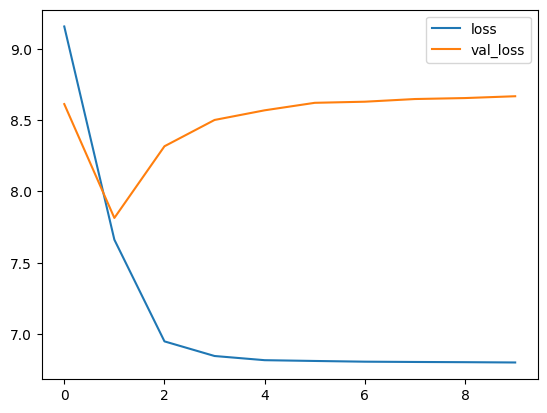

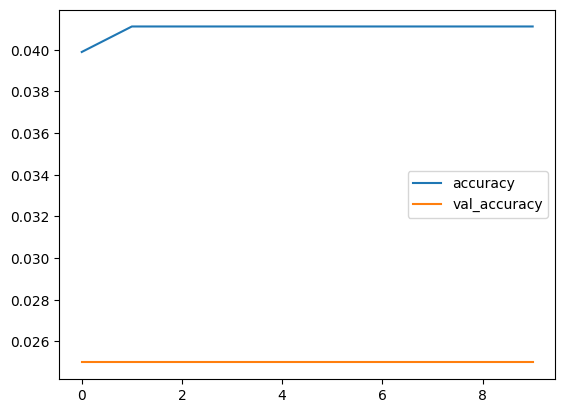

In [25]:
import matplotlib.pyplot as plt

model.save("model/model_02.h5")
render_history(history.history)

In [ ]:
import numpy as np

def generate(model, seed_text, generated_sequence_length, temperature):

    input_sequence = encoder(seed_text).numpy()

    generated_sequence = list(input_sequence[::])

    # Pad.
    padding = [0] * (sequence_length - len(input_sequence))
    input_sequence = padding + list(input_sequence)

    # Generate the sequence by repeatedly predicting.
    while len(generated_sequence) < generated_sequence_length:
        prediction = model.predict(np.expand_dims(input_sequence, axis=0), verbose=0)
        predicted_index = get_index_from_prediction(prediction[0], temperature)
        generated_sequence.append(predicted_index)
        input_sequence = input_sequence[1:]
        input_sequence.append(predicted_index)

    # Convert the generated sequence to a string.
    text = decode(generated_sequence)
    print(text)
    print("")


def get_index_from_prediction(prediction, temperature=0.0):
    """ Gets an index from a prediction. """
    # temperture extend the range of the norm, from deufult to uniform distribution

    # Zero temperature - use the argmax.
    if temperature == 0.0:
        return np.argmax(prediction)

    # Non-zero temperature - do some random magic.
    else:
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / temperature

        # Softmax
        exp_prediction= np.exp(prediction)
        prediction = exp_prediction / np.sum(exp_prediction) # Prob distribution

        probabilities = np.random.multinomial(1, prediction, 1)
        return np.argmax(probabilities)


generate(model, "we are all doomed", 100, temperature=1.0)